In [1]:
#Libraries

import pandas as pd
import numpy as np
from joblib import dump, load
from tensorflow.keras.models import load_model


from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, make_scorer, recall_score, f1_score, roc_curve, roc_auc_score,accuracy_score,classification_report


In [3]:
data=pd.read_csv(r'C:\Users\azad.aliyev\Downloads\data.csv')

In [99]:
num_anomalies = data[data['anomaly'] == 1].shape[0]
num_normal = data[data['anomaly'] == 0].shape[0]

print(f"Number of anomalies: {num_anomalies}")
print(f"Number of normal instances: {num_normal}")

Number of anomalies: 53648
Number of normal instances: 875250


In [117]:
X = data.drop(columns=['anomaly'])
y = data['anomaly']

In [118]:
X_train = X.iloc[:650000, :]
X_test = X.iloc[650000:, :]
y_train = y.iloc[:650000]
y_test = y.iloc[650000:]

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (650000, 20)
Test data shape: (278898, 20)


In [53]:
sampled_data = data.sample(n=100000, random_state=42)

In [27]:
sampled_data.head()

,FIT504,FIT401,FIT503,UV401_2,P501_2,PIT501,PIT503,FIT501,FIT502,P402_2,...,LIT401,MV304_2,AIT501,MV304_1,PIT502,AIT502,FIT301,P302_2,MV302_1,anomaly
693046,0.968680,0.989222,0.956915,1.0,1.0,0.928773,0.923433,0.989281,0.966895,1.0,...,0.877454,0.0,0.460236,1.0,0.323144,0.098584,0.927162,1.0,0.0,0.0
916789,0.972722,0.976684,0.959598,1.0,1.0,0.934097,0.925866,0.975208,0.953165,1.0,...,0.775993,0.0,0.450335,1.0,0.240175,0.910127,0.000000,0.0,1.0,1.0
292515,0.971509,0.978224,0.965633,1.0,1.0,0.953016,0.953930,0.978708,0.921565,1.0,...,0.767145,0.0,0.604918,1.0,0.283843,0.130668,0.000000,0.0,1.0,0.0
738953,0.000000,0.000000,0.001341,0.0,0.0,0.003445,0.001866,0.000510,0.000846,0.0,...,0.134079,1.0,0.162248,0.0,0.000000,0.490590,0.000000,0.0,1.0,1.0
748096,0.978986,0.973678,0.965968,1.0,1.0,0.947065,0.942494,0.971708,0.926644,1.0,...,0.258561,0.0,0.313638,1.0,0.262009,0.131924,0.927647,1.0,0.0,0.0


In [54]:
X = sampled_data.drop(columns=['anomaly'])
y = sampled_data['anomaly']

### Baseline with SMOTE implemented data

In [28]:
# Create a SMOTE object
smote = SMOTE(random_state=42)

# Resample the training set
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Checking the balance
print(y_train_smote.value_counts())

anomaly
0.0    75329
1.0    75329
Name: count, dtype: int64


In [92]:
experiment = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.01),
                             max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

experiment.fit(X_train_smote)  # Assuming you want to fit it to the resampled dataset

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, n_jobs=-1, random_state=42)

In [94]:
# Predictions
predictions = experiment.predict(X_test)

predictions = (predictions == -1).astype(int)  # Now 1 represents anomalies and 0 represents normal

accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.95
Recall: 0.7107
Precision: 0.9964
F1 Score: 0.8297


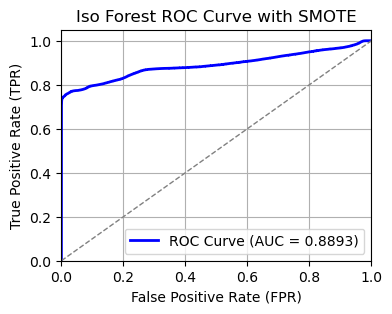

In [95]:
anomaly_scores = experiment.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, -anomaly_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Iso Forest ROC Curve with SMOTE')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [97]:
#model is trained on smote data and with 20 features
dump(experiment, r'C:\Users\Asus\Downloads\Thesis\models\model\iso\smote_iso_forest.joblib')

['C:\\Users\\Asus\\Downloads\\Thesis\\models\\model\\iso\\smote_iso_forest.joblib']

### Baseline with imbalanced data

In [98]:
experiment2 = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.01),
                             max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

experiment2.fit(X_train)  # Assuming you want to fit it to the resampled dataset

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, n_jobs=-1, random_state=42)

In [99]:
# Predictions
predictions = experiment2.predict(X_test)

predictions = (predictions == -1).astype(int)  # Now 1 represents anomalies and 0 represents normal

accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.96
Recall: 0.7444
Precision: 0.9857
F1 Score: 0.8482


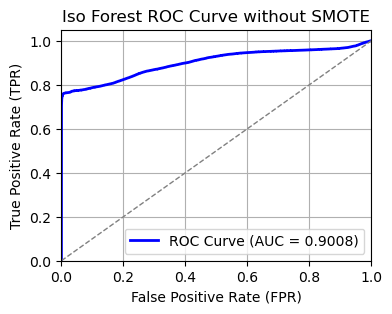

In [103]:
anomaly_scores = experiment2.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, -anomaly_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Iso Forest ROC Curve without SMOTE')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [102]:
#model is trained on inbalanced data and with 20 features
dump(experiment, r'C:\Users\Asus\Downloads\Thesis\models\model\iso\iso_forest.joblib')

['C:\\Users\\Asus\\Downloads\\Thesis\\models\\model\\iso\\iso_forest.joblib']

##  Optimization
**Grid Search** Best Parameters: {'contamination=0.01, max_features=0.9, max_samples=1.0, n_estimator=100}  
**Random Search** Best Parameters: { 'contamination': 0.013, 'n_estimators': 242, 'max_samples': 0.902, 'max_features': 0.876}  
**Bayesian** Best Parameters: (contamination=0.017, max_features=0.798, max_samples=0.846, n_estimators=173)  
**PSO** Best Parameters: (contamination=0.0397, n_estimators=62, random_state=42, max_sample='auto')  
**Hyperband** Best Parameters: (contamination=0.0129, max_features=0.887, max_samples=0.912, n_estimators=202)  

In [74]:
data = pd.read_csv(r'C:\Users\Asus\Downloads\Thesis\dataset\data.csv')

In [148]:
X = data.drop(columns=['anomaly'])
y = data['anomaly']

In [149]:
X_train = X.iloc[:650000, :]
X_test = X.iloc[650000:, :]
y_train = y.iloc[:650000]
y_test = y.iloc[650000:]

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (650000, 20)
Test data shape: (278898, 20)


### PSO optimization

In [7]:
X = sampled_data.drop(columns=['anomaly'])
y = sampled_data['anomaly']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (80000, 20)
Test data shape: (20000, 20)


In [14]:
from pyswarm import pso
from sklearn.metrics import precision_recall_fscore_support

In [15]:
def f1_precision_optimize(params):
    # Assuming params array contains the parameters to optimize, e.g., contamination and n_estimators
    clf = IsolationForest(n_estimators=int(params[0]), contamination=params[1])
    clf.fit(X_train)
    preds = clf.predict(X_test)
    # Convert preds to binary output
    preds = [1 if x == -1 else 0 for x in preds]
    # Calculate precision, recall, and F1 Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')
    # You might consider a weighted objective to also increase precision
    weighted_score = f1 + 0.5 * precision  # Adjust weighting as needed
    return -weighted_score  # Negate because pyswarm minimizes the function

# Define bounds for each parameter, e.g., n_estimators and contamination
lb = [50, 0.01]  # Lower bounds
ub = [200, 0.1]  # Upper bounds

# Run PSO
xopt, fopt = pso(f1_precision_optimize, lb, ub)

print("Best parameters found:", xopt)
print("Best negative weighted score found:", fopt)

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

Stopping search: maximum iterations reached --> 100
Best parameters found: [6.28218371e+01 3.97081345e-02]
Best negative weighted score found: -1.1750414479822515


In [16]:
n_estimators = int(62.82)  # Rounding the number of trees
contamination = 0.0397  # Proportion of outliers

In [17]:
iso_forest = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)

In [32]:
iso_forest.fit(X_train_smote)

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.0397, n_estimators=62, random_state=42)

In [33]:
# Predictions
predictions = iso_forest.predict(X_test)

predictions = (predictions == -1).astype(int)  # Now 1 represents anomalies and 0 represents normal

accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.97
Recall: 0.5734
Precision: 0.8624
F1 Score: 0.6889


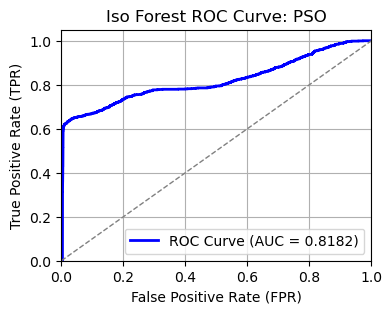

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

anomaly_scores = iso_forest.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, -anomaly_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Iso Forest ROC Curve: PSO')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [25]:
dump(iso_forest, r'C:\Users\Asus\Downloads\Thesis\models\model\iso\pso_iso_forest.joblib')

['C:\\Users\\Asus\\Downloads\\Thesis\\models\\model\\iso\\pso_iso_forest.joblib']

### Hyperband Optimization

In [5]:
import optuna
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Baseline metrics
baseline_accuracy = 0.96
baseline_recall = 0.7444
baseline_precision = 0.9857
baseline_f1 = 0.8482
baseline_auc = 0.9008

# Baseline hyperparameters
baseline_params = {
    "contamination": 0.01,
    "n_estimators": 100,
    "max_samples": "auto",
    "max_features": 1.0,
    "random_state": 42,
}

In [238]:
sampled_data = data.sample(n=1000, random_state=42)

X = sampled_data.drop(columns=['anomaly'])
y = sampled_data['anomaly']

# Step 1: Prepare sampled data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
def objective(trial):
    # Refined hyperparameter suggestions
    contamination = trial.suggest_float("contamination", 0.005, 0.02)  # Around true anomaly ratio
    n_estimators = trial.suggest_int("n_estimators", 100, 500)  # Larger range
    max_samples = trial.suggest_float("max_samples", 0.3, 1.0)  # Subsample size
    max_features = trial.suggest_float("max_features", 0.5, 1.0)  # Fraction of features
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])  # Optional hyperparameter

    # Initialize Isolation Forest
    model = IsolationForest(
        contamination=contamination,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1,
    )
    normal_data_train = X_train[y_train == 0]
    model.fit(normal_data_train)

    # Predict anomalies on the test set
    y_pred = model.predict(X_test)
    y_pred = (y_pred == -1).astype(int)  # Convert to binary (1 = anomaly)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    # Compare with baseline
    if f1 < 0.75:  # Penalize if F1 Score is worse than 0.75
        return -1
    else:
        return 0.3 * f1 + 0.2 * recall + 0.2 * precision + 0.2 * auc + 0.1 * accuracy

In [47]:
# Step 2: Configure Optuna with Hyperband
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner(min_resource=10, max_resource=50)
)

# Step 3: Run the optimization
study.optimize(objective, n_trials=400, n_jobs=-1, timeout=3600)

# Step 4: Display the best parameters and comparison with baseline
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-12-01 05:00:52,217] A new study created in memory with name: no-name-87ff5cca-3bc8-4aa3-8c1c-cb9bdd1487ed
[I 2024-12-01 05:00:54,906] Trial 0 finished with value: -1.0 and parameters: {'contamination': 0.016626970665936044, 'n_estimators': 103, 'max_samples': 0.6819922060085521, 'max_features': 0.5548605501356114, 'bootstrap': False}. Best is trial 0 with value: -1.0.
[I 2024-12-01 05:00:54,958] Trial 5 finished with value: -1.0 and parameters: {'contamination': 0.007110530012720984, 'n_estimators': 106, 'max_samples': 0.7312660230697101, 'max_features': 0.8663585998371646, 'bootstrap': False}. Best is trial 0 with value: -1.0.
[I 2024-12-01 05:00:55,200] Trial 7 finished with value: -1.0 and parameters: {'contamination': 0.00679551577471057, 'n_estimators': 127, 'max_samples': 0.5349860529324648, 'max_features': 0.5822195787790105, 'bootstrap': False}. Best is trial 0 with value: -1.0.
[I 2024-12-01 05:00:55,504] Trial 11 finished with value: -1.0 and parameters: {'contaminati

Best hyperparameters: {'contamination': 0.012874225237532346, 'n_estimators': 202, 'max_samples': 0.9120826344316799, 'max_features': 0.8868952718202318, 'bootstrap': True}


In [61]:
best_model = IsolationForest(
    contamination=best_params["contamination"],
    n_estimators=best_params["n_estimators"],
    max_samples=best_params["max_samples"],
    max_features=best_params["max_features"],
    random_state=42,
    bootstrap=best_params["bootstrap"],
    n_jobs=-1,
)

In [65]:
normal_data_train = X_train[y_train == 0]
best_model.fit(normal_data_train)

IsolationForest(bootstrap=True, contamination=0.012874225237532346,
                max_features=0.8868952718202318, max_samples=0.9120826344316799,
                n_estimators=202, n_jobs=-1, random_state=42)

In [67]:
y_pred = best_model.predict(X_test)
y_pred = (y_pred == -1).astype(int)

# Final evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Baseline Metrics:")
print(f"Accuracy: {baseline_accuracy}, Recall: {baseline_recall}, Precision: {baseline_precision}, F1 Score: {baseline_f1}, AUC: {baseline_auc}")

print("Optimized Model Metrics:")
print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")

Baseline Metrics:
Accuracy: 0.96, Recall: 0.7444, Precision: 0.9857, F1 Score: 0.8482, AUC: 0.9008
Optimized Model Metrics:
Accuracy: 0.9750, Recall: 0.6923, Precision: 0.9000, F1 Score: 0.7826, AUC: 0.8435


In [232]:
X = data.drop(columns=['anomaly'])
y = data['anomaly']

X_train = X.iloc[:650000, :]
X_test = X.iloc[650000:, :]
y_train = y.iloc[:650000]
y_test = y.iloc[650000:]

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (650000, 20)
Test data shape: (278898, 20)


### Bayesian Optimization with optuna

In [71]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Baseline metrics
baseline_accuracy = 0.96
baseline_recall = 0.7444
baseline_precision = 0.9857
baseline_f1 = 0.8482
baseline_auc = 0.9008

# Define search space
search_space = [
    Real(0.005, 0.02, name="contamination"),  # Proportion of anomalies
    Integer(100, 500, name="n_estimators"),  # Number of trees
    Real(0.3, 1.0, name="max_samples"),  # Fraction of samples
    Real(0.5, 1.0, name="max_features"),  # Fraction of features
]

In [105]:
@use_named_args(search_space)
def objective(contamination, n_estimators, max_samples, max_features):
    # Train the Isolation Forest model
    model = IsolationForest(
        contamination=contamination,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        random_state=42,
        n_jobs=-1,
    )
    normal_data_train = X_train[y_train == 0]
    model.fit(normal_data_train)

    # Predict anomalies
    y_pred = model.predict(X_test)
    y_pred = (y_pred == -1).astype(int)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    # Penalize models that perform worse than 0.75
    if f1 < 0.75:
        return -1
    return -0.3 * f1 - 0.2 * recall - 0.2 * precision - 0.2 * auc - 0.1 * accuracy


In [123]:
def parallel_gp_minimize():
    # Use Parallel from joblib to run multiple trials concurrently
    results = Parallel(n_jobs=-1)(
        delayed(objective)(
            contamination=contamination,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features,
        )
        for contamination, n_estimators, max_samples, max_features in zip(
            np.random.uniform(0.005, 0.02, 10),
            np.random.randint(100, 500, 10),
            np.random.uniform(0.3, 1.0, 10),
            np.random.uniform(0.5, 1.0, 10),
        )
    )
    return results

# Run the parallelized optimization
result = gp_minimize(
    objective, search_space, n_calls=50, n_jobs=-1, random_state=42
)

# Display the best hyperparameters
print("Best Parameters:", result.x)
print("Best Score:", -result.fun)

Best Parameters: [0.016948144802903495, 173, 0.8457837001909385, 0.7984250789732436]
Best Score: 1


In [125]:
best_params = {
    "contamination": result.x[0],
    "n_estimators": result.x[1],
    "max_samples": result.x[2],
    "max_features": result.x[3],
}
best_model = IsolationForest(
    contamination=best_params["contamination"],
    n_estimators=best_params["n_estimators"],
    max_samples=best_params["max_samples"],
    max_features=best_params["max_features"],
    random_state=42,
    n_jobs=-1,
)

In [141]:
normal_data_train = X_train[y_train == 0]
best_model.fit(normal_data_train)

IsolationForest(contamination=0.016948144802903495,
                max_features=0.7984250789732436, max_samples=0.8457837001909385,
                n_estimators=173, n_jobs=-1, random_state=42)

In [133]:
y_pred = best_model.predict(X_test)
y_pred = (y_pred == -1).astype(int)

# Final evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Baseline Metrics:")
print(f"Accuracy: {baseline_accuracy}, Recall: {baseline_recall}, Precision: {baseline_precision}, F1 Score: {baseline_f1}, AUC: {baseline_auc}")

print("Optimized Model Metrics:")
print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")

Baseline Metrics:
Accuracy: 0.96, Recall: 0.7444, Precision: 0.9857, F1 Score: 0.8482, AUC: 0.9008
Optimized Model Metrics:
Accuracy: 0.9509, Recall: 0.7634, Precision: 0.9144, F1 Score: 0.8321, AUC: 0.8749


### Random Search Optimization

In [145]:
param_space = {
    "contamination": (0.005, 0.02),  # Contamination range
    "n_estimators": (100, 500),  # Number of trees
    "max_samples": (0.3, 1.0),  # Fraction of samples
    "max_features": (0.5, 1.0),  # Fraction of features
}

In [155]:
# Generate a random configuration
def sample_hyperparameters():
    return {
        "contamination": np.random.uniform(*param_space["contamination"]),
        "n_estimators": np.random.randint(*param_space["n_estimators"]),
        "max_samples": np.random.uniform(*param_space["max_samples"]),
        "max_features": np.random.uniform(*param_space["max_features"]),
    }

# Define the evaluation function
def evaluate_hyperparameters(params):
    # Train Isolation Forest
    model = IsolationForest(
        contamination=params["contamination"],
        n_estimators=params["n_estimators"],
        max_samples=params["max_samples"],
        max_features=params["max_features"],
        random_state=42,
        n_jobs=-1,
    )
    normal_data_train = X_train[y_train == 0]
    model.fit(normal_data_train)
    
    # Predict anomalies
    y_pred = model.predict(X_test)
    y_pred = (y_pred == -1).astype(int)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    # Compare with baseline metrics
    if f1 < 0.75:
        return None  # Ignore configurations that perform worse than baseline

    return {
        "params": params,
        "metrics": {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc,
        },
    }

In [157]:
from joblib import Parallel, delayed

# Run Random Search with Parallelization
n_trials = 50  # Number of random configurations to evaluate
results = Parallel(n_jobs=-1)(
    delayed(evaluate_hyperparameters)(sample_hyperparameters()) for _ in range(n_trials)
)

# Filter out None results
results = [result for result in results if result is not None]

# Find the best configuration
if results:
    best_result = max(results, key=lambda x: x["metrics"]["f1"])
    print("Best Hyperparameters:", best_result["params"])
    print("Best Metrics:", best_result["metrics"])
else:
    print("No configuration outperformed the baseline.")

Best Hyperparameters: {'contamination': 0.013331863973399468, 'n_estimators': 242, 'max_samples': 0.9019217905074726, 'max_features': 0.8755751936708458}
Best Metrics: {'accuracy': 0.975, 'precision': 0.9, 'recall': 0.6923076923076923, 'f1': 0.782608695652174, 'auc': 0.8434800493624023}


In [163]:
best_model = IsolationForest(
    contamination=best_result["params"]["contamination"],
    n_estimators=best_result["params"]["n_estimators"],
    max_samples=best_result["params"]["max_samples"],
    max_features=best_result["params"]["max_features"],
    random_state=42,
    n_jobs=-1,
)

In [165]:
normal_data_train = X_train[y_train == 0]
best_model.fit(normal_data_train)

IsolationForest(contamination=0.013331863973399468,
                max_features=0.8755751936708458, max_samples=0.9019217905074726,
                n_estimators=242, n_jobs=-1, random_state=42)

In [171]:
y_pred = best_model.predict(X_test)
y_pred = (y_pred == -1).astype(int)

# Final evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Baseline Metrics:")
print(f"Accuracy: {baseline_accuracy}, Recall: {baseline_recall}, Precision: {baseline_precision}, F1 Score: {baseline_f1}, AUC: {baseline_auc}")

print("Optimized Model Metrics:")
print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")

Baseline Metrics:
Accuracy: 0.96, Recall: 0.7444, Precision: 0.9857, F1 Score: 0.8482, AUC: 0.9008
Optimized Model Metrics:
Accuracy: 0.9563, Recall: 0.7574, Precision: 0.9599, F1 Score: 0.8467, AUC: 0.8757


In [182]:
param_grid = {
    "contamination": [0.005, 0.01, 0.015, 0.02],  # Proportion of anomalies
    "n_estimators": [100, 200, 300, 400],         # Number of trees
    "max_samples": [0.5, 0.7, 0.9, 1.0],          # Fraction of samples
    "max_features": [0.5, 0.7, 0.9, 1.0],         # Fraction of features
}

In [186]:
from itertools import product

# Create all combinations of hyperparameters
param_combinations = list(product(
    param_grid["contamination"],
    param_grid["n_estimators"],
    param_grid["max_samples"],
    param_grid["max_features"],
))

In [242]:
# Define the evaluation function
def evaluate_params(params):
    contamination, n_estimators, max_samples, max_features = params
    model = IsolationForest(
        contamination=contamination,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        random_state=42,
        n_jobs=-1,
    )
    normal_data_train = X_train[y_train == 0]
    model.fit(normal_data_train)

    # Predict anomalies
    y_pred = model.predict(X_test)
    y_pred = (y_pred == -1).astype(int)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    # Compare with baseline
    if f1 < 0.75:
        return None  # Ignore configurations that perform worse than the baseline

    return {
        "params": params,
        "metrics": {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc,
        },
    }

In [244]:
# Run Grid Search with Parallelization
results = Parallel(n_jobs=-1)(
    delayed(evaluate_params)(params) for params in param_combinations
)

# Filter out None results
results = [result for result in results if result is not None]

# Find the best configuration
if results:
    best_result = max(results, key=lambda x: x["metrics"]["f1"])
    print("Best Hyperparameters:", best_result["params"])
    print("Best Metrics:", best_result["metrics"])
else:
    print("No configuration outperformed the baseline.")

Best Hyperparameters: (0.01, 100, 1.0, 0.9)
Best Metrics: {'accuracy': 0.975, 'precision': 0.9, 'recall': 0.6923076923076923, 'f1': 0.782608695652174, 'auc': 0.8434800493624023}


In [206]:
best_model = IsolationForest(
    contamination=0.01,
    n_estimators=100,
    max_samples=1.0,
    max_features=0.9,
    random_state=42,
    n_jobs=-1,
)

In [220]:
normal_data_train = X_train[y_train == 0]
best_model.fit(normal_data_train)

IsolationForest(contamination=0.01, max_features=0.9, max_samples=1.0,
                n_jobs=-1, random_state=42)

In [230]:
y_pred = best_model.predict(X_test)
y_pred = (y_pred == -1).astype(int)

# Final evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("Baseline Metrics:")
print(f"Accuracy: {baseline_accuracy}, Recall: {baseline_recall}, Precision: {baseline_precision}, F1 Score: {baseline_f1}, AUC: {baseline_auc}")

print("Optimized Model Metrics:")
print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")

Baseline Metrics:
Accuracy: 0.96, Recall: 0.7444, Precision: 0.9857, F1 Score: 0.8482, AUC: 0.9008
Optimized Model Metrics:
Accuracy: 0.9754, Recall: 0.6404, Precision: 0.9684, F1 Score: 0.7710, AUC: 0.8195


## Different Splitting

### k-fold cross validation

In [108]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
import tensorflow as tf

In [109]:
sampled_data = data.sample(n=10000, random_state=42)
X = sampled_data.drop(columns=['anomaly'])
y = sampled_data['anomaly']

In [110]:
iso_grid=load(r'C:\Users\Asus\Downloads\Thesis\models\model\iso\gs_iso_forest_model.joblib')
iso_random=load(r'C:\Users\Asus\Downloads\Thesis\models\model\iso\rs_iso_forest_model.joblib')
iso_bayes=load(r'C:\Users\Asus\Downloads\Thesis\models\model\iso\bs_iso_forest_model.joblib')
iso_pso=load(r'C:\Users\Asus\Downloads\Thesis\models\model\iso\pso_iso_forest.joblib')
hb_iso=load(r'C:\Users\Asus\Downloads\Thesis\models\model\iso\hb_iso.joblib')

In [115]:
# Assuming `ocsvm_model_1` and `ocsvm_model_2` are your loaded OCSVM models
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

auc_scores_model_1 = []
auc_scores_model_2 = []
auc_scores_model_3 = []
auc_scores_model_4 = []
auc_scores_model_5 = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    
    # PSO
    iso_pso.fit(X_train)
    scores_model_1 = iso_pso.decision_function(X_test)
    scores_model_1 = -scores_model_1  # Adjust if necessary
    fpr_1, tpr_1, _ = roc_curve(y_test, scores_model_1)
    auc_scores_model_1.append(auc(fpr_1, tpr_1))
    

    # Grid
    iso_grid.fit(X_train)
    scores_model_2 = iso_grid.decision_function(X_test)
    scores_model_2 = -scores_model_2  # Adjust if necessary
    fpr_2, tpr_2, _ = roc_curve(y_test, scores_model_2)
    auc_scores_model_2.append(auc(fpr_2, tpr_2))
    
    # Random
    iso_random.fit(X_train)
    scores_model_3 = iso_random.decision_function(X_test)
    scores_model_3 = -scores_model_3  # Adjust if necessary
    fpr_3, tpr_3, _ = roc_curve(y_test, scores_model_3)
    auc_scores_model_3.append(auc(fpr_3, tpr_3))

    # Bayesian
    iso_bayes.fit(X_train)
    scores_model_4 = iso_bayes.decision_function(X_test)
    scores_model_4 = -scores_model_4  # Adjust if necessary
    fpr_4, tpr_4, _ = roc_curve(y_test, scores_model_4)
    auc_scores_model_4.append(auc(fpr_4, tpr_4))
    
    # Hyoerband
    experiment.fit(X_train)
    scores_model_5 = experiment.decision_function(X_test)
    scores_model_5 = -scores_model_5  # Adjust if necessary
    fpr_5, tpr_5, _ = roc_curve(y_test, scores_model_5)
    auc_scores_model_5.append(auc(fpr_5, tpr_5))


C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid fe

C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


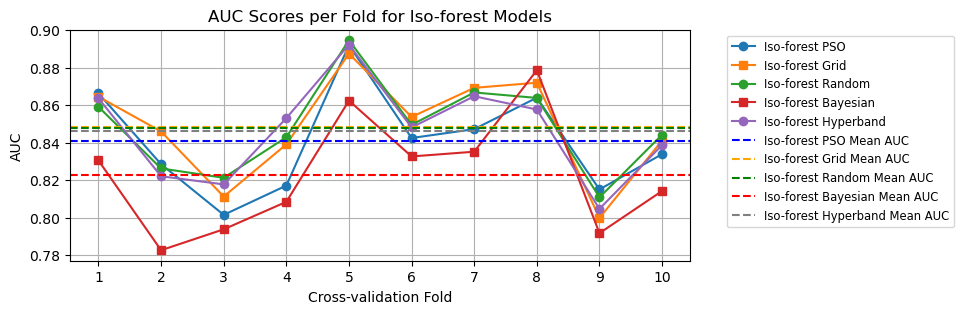

In [116]:
import matplotlib.pyplot as plt

# Plotting AUC scores for both models
plt.figure(figsize=(8, 3))
folds = list(range(1, len(auc_scores_model_1) + 1))

plt.plot(folds, auc_scores_model_1, marker='o', label='Iso-forest PSO')
plt.plot(folds, auc_scores_model_2, marker='s', label='Iso-forest Grid')
plt.plot(folds, auc_scores_model_3, marker='o', label='Iso-forest Random')
plt.plot(folds, auc_scores_model_4, marker='s', label='Iso-forest Bayesian')
plt.plot(folds, auc_scores_model_5, marker='o', label='Iso-forest Hyperband')


# Add mean AUC as horizontal lines
plt.axhline(np.mean(auc_scores_model_1), color='blue', linestyle='--', label='Iso-forest PSO Mean AUC')
plt.axhline(np.mean(auc_scores_model_2), color='orange', linestyle='--', label='Iso-forest Grid Mean AUC')
plt.axhline(np.mean(auc_scores_model_3), color='green', linestyle='--', label='Iso-forest Random Mean AUC')
plt.axhline(np.mean(auc_scores_model_4), color='red', linestyle='--', label='Iso-forest Bayesian Mean AUC')
plt.axhline(np.mean(auc_scores_model_5), color='grey', linestyle='--', label='Iso-forest Hyperband Mean AUC')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.xlabel('Cross-validation Fold')
plt.ylabel('AUC')
plt.title('AUC Scores per Fold for Iso-forest Models')
plt.xticks(folds)
plt.grid(True)
plt.show()

#### k-fold only choosen grid search

In [131]:
isolation_forest = load(r'C:\Users\Asus\Downloads\Thesis\models\model\iso\gs_iso_forest_model.joblib')

In [133]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
auc_scores = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE to training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    
    # Predict on test data - Isolation Forest uses decision_function to generate anomaly scores
    scores = isolation_forest.decision_function(X_test)
    scores = -scores  # Higher scores are more anomalous

    # Compute ROC AUC
    fpr, tpr, thresholds = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

    # fpr, tpr for later use in plotting ROC curves
    fold_predictions.append((fpr, tpr))

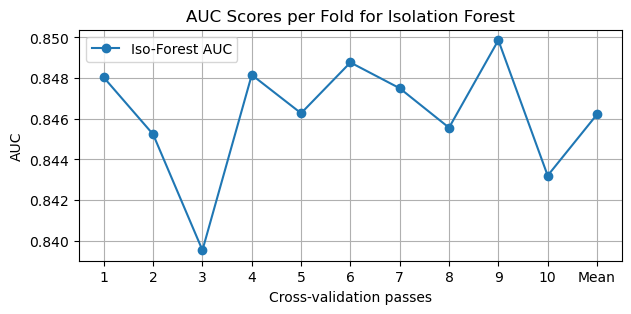

In [135]:
plt.figure(figsize=(7, 3))
plt.plot(range(1, 12), auc_scores + [np.mean(auc_scores)], marker='o', label='Iso-Forest AUC')
plt.xticks(list(range(1, 12)), labels=list(range(1, 11)) + ['Mean'])
plt.xlabel('Cross-validation passes')
plt.ylabel('AUC')
plt.title('AUC Scores per Fold for Isolation Forest')
plt.legend()
plt.grid(True)
plt.show()

In [173]:
model = load(r'C:\Users\Asus\Downloads\Thesis\models\model\iso\iso_forest.joblib')

### 80/20 Test Splitting

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (743118, 20)
Test data shape: (185780, 20)


In [167]:
# Predictions
predictions = model.predict(X_test)
predictions = (predictions == -1).astype(int)  # Now 1 represents anomalies and 0 represents normal

accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.97
Recall: 0.5846
Precision: 0.8996
F1 Score: 0.7087


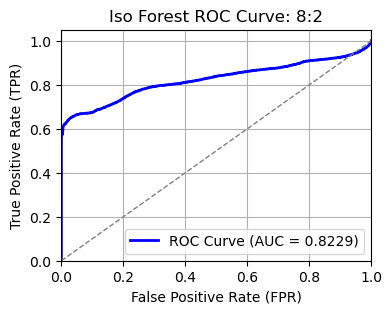

In [171]:
anomaly_scores = model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, -anomaly_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Iso Forest ROC Curve: 8:2')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 90/10 Test Splitting

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (836008, 20)
Test data shape: (92890, 20)


In [174]:
# Predictions
predictions = model.predict(X_test)
predictions = (predictions == -1).astype(int)  # Now 1 represents anomalies and 0 represents normal

accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.97
Recall: 0.5882
Precision: 0.9006
F1 Score: 0.7116


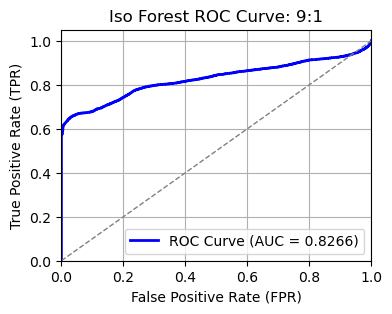

In [176]:
anomaly_scores = model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, -anomaly_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Iso Forest ROC Curve: 9:1')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 60/40 Test Splitting

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (557338, 20)
Test data shape: (371560, 20)


In [178]:
# Predictions
predictions = model.predict(X_test)
predictions = (predictions == -1).astype(int)  # Now 1 represents anomalies and 0 represents normal

accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.97
Recall: 0.5896
Precision: 0.8990
F1 Score: 0.7122


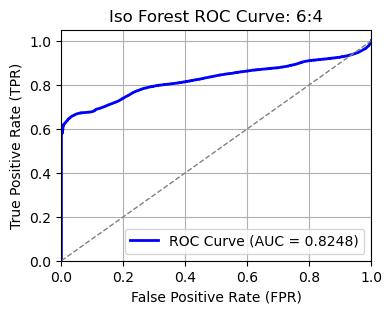

In [180]:
anomaly_scores = model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, -anomaly_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Iso Forest ROC Curve: 6:4')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 70/30 Test Splitting

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (650228, 20)
Test data shape: (278670, 20)


In [182]:
# Predictions
predictions = model.predict(X_test)
predictions = (predictions == -1).astype(int)  # Now 1 represents anomalies and 0 represents normal

accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.97
Recall: 0.5912
Precision: 0.8998
F1 Score: 0.7136


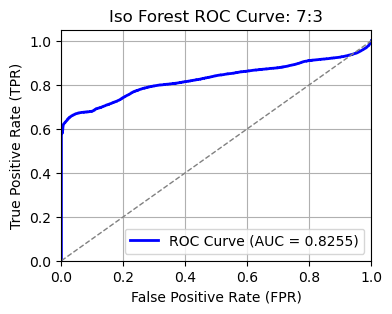

In [184]:
anomaly_scores = model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, -anomaly_scores)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Iso Forest ROC Curve: 7:3')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### AUC curve results per splitting ratio

In [9]:
split_ratios = ['7:3', '6:4', '9:1', '8:2']
auc_scores = [0.8255, 0.8248, 0.8266, 0.8229]

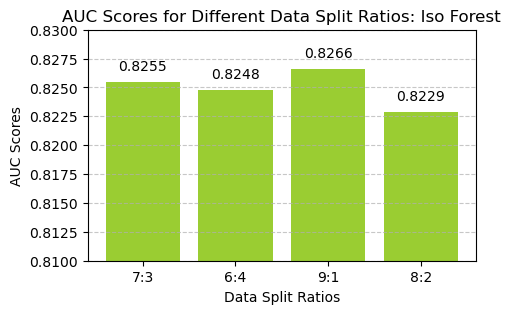

In [10]:
# Creating the plot
plt.figure(figsize=(5, 3))
plt.bar(split_ratios, auc_scores, color='yellowgreen')

# Adding titles and labels
plt.xlabel('Data Split Ratios')
plt.ylabel('AUC Scores')
plt.title('AUC Scores for Different Data Split Ratios: Iso Forest')
plt.ylim([0.81, 0.83])  # Adjust the y-axis limits to make differences more visible

# Adding the AUC scores on top of each bar for clarity
for i in range(len(auc_scores)):
    plt.text(i, auc_scores[i] + 0.001, f'{auc_scores[i]:.4f}', ha = 'center', color = 'black')

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()